In [33]:

!pip install --upgrade pip
!pip install moviepy
!pip install imageio-ffmpeg

Requirement already up-to-date: pip in /opt/conda/lib/python3.6/site-packages (19.1)


In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import pickle
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image

from matplotlib.patches import Polygon
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [35]:
# Get the distortion coefficient and camera matrix using pickle
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [36]:
# initialisation values:
#fit_pol_win_lane=0
#fit_pol_prev_lane=0

#left_fit = np.array([ 1, 1, 0])
#right_fit = np.array([ 1, 1, 0])

In [25]:
# Refer to chessboard_corner for the calculation of the camera matrix and the distortion matrix#
# serealise the matrix using pickle (stored under camera_cal/wide_dist_pickle.p)#
# retrive the distortion and camera matrix from pickle#
def adv_lane_det(image_raw):
    dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    image_read = image_raw
    img_size= (image_read.shape[1], image_read.shape[0])

    # color binary

    def color_binary(img,gray_thresh=(230, 255), h_thresh=(230, 255),l_thresh= (240, 255),s_thresh=(150, 255), sx_thresh=(70, 100)):
        img = np.copy(img)

        # binary image from grayscale
        image_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        binary_gray = np.zeros_like(image_gray)
        binary_gray [(image_gray > gray_thresh[0]) & (image_gray <= gray_thresh[1])] = 1

        # Convert to HLS color space and separate the V channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        h_channel = hls[:,:,0]
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # Threshold color channel
        h_binary = np.zeros_like(h_channel)
        h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

         # Threshold color channel
        l_binary = np.zeros_like(l_channel)
        l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

        binary_combined = (binary_gray)|(sxbinary)|(h_binary)|(l_binary)|(s_binary)
        # Stack each channel)
        #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
        color_binary = np.dstack(( binary_combined,binary_combined,binary_combined)) * 255
        return color_binary

    image_CB = color_binary(image_read)

    # The Histogram does not work if it has a 3rd dimension  therfore reduced to single chjanel
    image_CB= image_CB[:,:,2]

    #undistort image using the values retrived from pickle
    def corners_unwarp(img, mtx, dist):
        dst = cv2.undistort(img, mtx, dist, None, mtx)

        #define source and destination
        # defining the 4 points of the source
        xsize = img.shape[1]
        ysize = img.shape[0]
        left_bottom_s = (230, ysize -50)
        left_top_s = (xsize / 2 - 55, ysize / 2 +90)
        right_bottom_s = (xsize - 235, ysize -50)
        right_top_s = (xsize / 2 + 50, ysize / 2 + 90)
        src = np.float32([(left_bottom_s), (left_top_s), (right_top_s), (right_bottom_s)])
        #src = np.float32([(230, 670),( 590, 448),(688, 448),(1050, 670)]) derived from Straight_lines1.jpg manualy (trial and error)

        # defining the 4 points of the destination
        left_bottom_d = (320, ysize)
        left_top_d = (320, 0)
        right_bottom_d = (xsize - 340, ysize )
        right_top_d = (xsize - 345 , 0)
        dst = np.float32([(left_bottom_d), (left_top_d), (right_top_d), (right_bottom_d)])
        # dst = np.float32([(320, 720),(320, 0),(960, 0),(960, 720)]) deduced for Straight_lines1.jpg manualy

        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

        #inverse Transform needed when the lane marked on the warped image has to be brought back to the camera perspective
        M_Inv = cv2.getPerspectiveTransform(dst, src)

        return warped, M, M_Inv

    Image_top_down, perspective_M, Inverse_M = corners_unwarp(image_CB), mtx, dist)

    #########################################################################
    ##---- Fit sliding windows----------------####
    #########################################################################

    def find_lane_pixels(binary_warped):
        # Take a histogram of the bottom half of the image

        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)

        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        #print(histogram))
        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image--> not required
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            #(win_xleft_high,win_y_high),(0,255,0), 2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),
            #(win_xright_high,win_y_high),(0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty, out_img


    def fit_polynomial(binary_warped):
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')

        return out_img, left_fit, right_fit, left_fitx, right_fitx

    Image_fit, left_fit_prev, right_fit_prev,left_fitx, right_fitx = fit_polynomial(Image_top_down)
    #######################################################################
    # --- find lane from previous-----#####
    #######################################################################

    # Load our image - this should be a new frame since last time!
    # Manual trial
    #[ 2.76657214e-04 -5.36742976e-01  6.32736498e+02]
    #[ 1.66092155e-04 -3.23694165e-01  1.12134046e+03]
    # Polynomial fit values from the previous frame
    # Make sure to grab the actual values from the previous step in your project!
    left_fit = left_fit_prev
    right_fit = right_fit_prev

    def fit_poly(img_shape, leftx, lefty, rightx, righty):

        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        return left_fitx, right_fitx, ploty

    def search_around_poly(binary_warped):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])


        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
        #print(left_fitx.shape[0])
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##


        return result ,left_fitx, right_fitx, leftx , rightx

    # Run image through the pipeline
    # Note that in your project, you'll also want to feed in the previous fits
    #image_fit, left_x, right_x = search_around_poly(Image_top_down)
    # View your output
    #plt.imshow(image_fit)

    ### calculate the radius of curvature###

    def curvature_radius (leftx, rightx, img_shape):
            
        ploty = np.linspace(0, img_shape[1]-1, img_shape[1]) # generate equaly spaced Y co-ordinates
        #print(ploty.shape)

        # Fit a second order polynomial to pixel positions in each fake lane line
        #print(ploty.shape[0])

        #left_fitx = leftx[0]*ploty**2 + leftx[1]*ploty + leftx[2] #fit left polynomial
        #right_fitx = rightx[0]*ploty**2 + rightx[1]*ploty + rightx[2]#fit left polynomial
        # Define conversions in x and y from pixels space to meters as was used in the classes
        ym_per_pix = 25/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/800 # meters per pixel in x dimension (actual lane is approximately 3.7 m wide)
        #print("printing left Co efficients [",leftx,"]")
        #print("printing right Co efficients[",rightx,"]")
        #print("printing left fitpoints",left_fitx)
        #print("printing right fitpoints",right_fitx)
        # Fit new polynomials to x,y in world space
        y_eval = np.max(ploty) 
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2) # derive thecoefficients of the polynomial on the real left curve
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)# derive thecoefficients of the polynomial on the real right curve
        #print("printing actual left lane Co efficients",left_fit_cr)
        #print("printing actual right lane Co efficients",right_fit_cr)
        # Calculate the new radii of curvature using the formula R=[(1+(2Ay+B)²)³/2]/|2A|
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0]) # curve radius left
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])# curve radius right
        #print("left curve radius",left_curverad)
        #print("left curve radius",right_curverad)
        ############################
        # - 5.2 Calculate offset-##
        ############################

        # Calculate mid point of image in the x-direction (refernce midpoint of the vehicle)
        Mid_point_img = img_shape[0]//2
        #print("image mid point",Mid_point_img)
        # calculate mid point of lane
        Mid_point_lane = (left_fitx[-1] + right_fitx[-1])/2
        #print("lane mid point",Mid_point_lane)
        #print("left_fitx",left_fitx)
        #print("right_fitx",right_fitx)
        # calculate offset
        offset_x = (Mid_point_img- Mid_point_lane)* xm_per_pix
        # Now our radius of curvature is in meters
        return (left_curverad, right_curverad, offset_x)

    img_shape_fit = (Image_top_down.shape[1], Image_top_down.shape[0])
    left_c, right_c, offset = curvature_radius (left_fit, right_fit, img_shape_fit)
    #print("left radius is",left_c,"m")
    #print("right radius is",right_c,"m")
    #print("vehicle offset is",offset,"m")
    #############################################
    ### add the lanes to the original image#####
    ############################################

    def rev_transform(img, warped_img, left_points, right_points, Minv):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        left_fitx = left_points[0]
        right_fitx = right_points[0]
        ploty = left_points[1]

        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (50,200, 200))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

        # Combine the result with the original image
        return cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    ploty = np.linspace(0, Image_top_down.shape[0]-1, Image_top_down.shape[0] )
    left_points=(left_fitx, ploty)
    right_points=(right_fitx, ploty)
    image_lane = rev_transform(image_read, Image_top_down, left_points, right_points, Inverse_M )
    
    ###############################################
    #- 7. Print curvature and offset on to image-##
    ###############################################
    #source:https://stackoverflow.com/questions/16615662/how-to-write-text-on-a-image-in-windows-using-python-opencv2

    def Print_on_img(img, left_c, right_c,ofs):
        # Display lane curvature
        out_img = img.copy()
        cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(left_c), 
                    (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 5)
        cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(right_c), 
                    (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 5)

        # Display car offset
        cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(ofs), 
                    (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 5)

        return out_img

    Image_f=Print_on_img(image_lane, left_c, right_c,offset)

    return (Image_f)



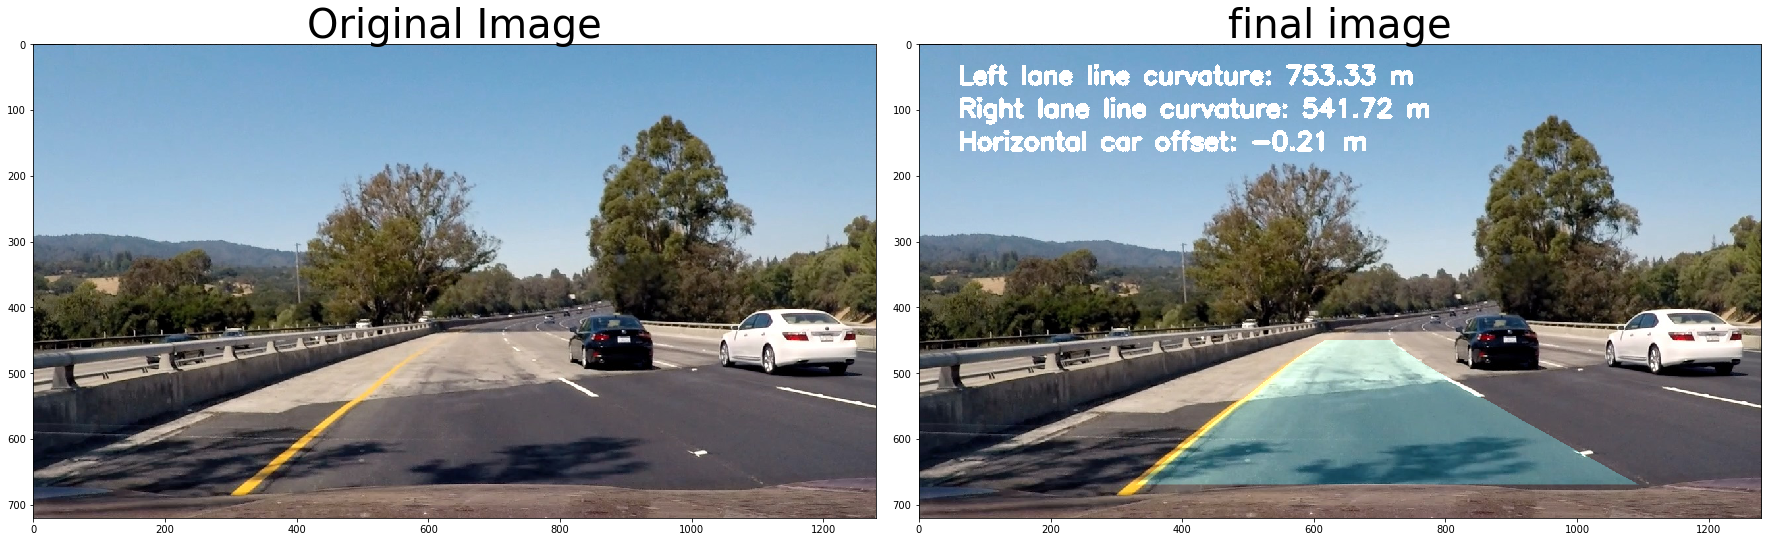

In [26]:
#Test run final image

Image_1 = mpimg.imread('test_images/test4.jpg')
Image_final = adv_lane_det(Image_1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(Image_1)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(Image_final)
ax2.set_title('final image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [30]:
Input_video = 'project_video.mp4'
Output_video = 'Output_videos/project_video_Solution_SK.mp4'

white_output = Output_video
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip(Input_video)
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(adv_lane_det) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
HTML("""<video width="480" height="270" controls><source src="{0}"></video>""".format(white_output))

[MoviePy] >>>> Building video Output_videos/project_video_Solution_SK.mp4
[MoviePy] Writing video Output_videos/project_video_Solution_SK.mp4


100%|█████████▉| 1260/1261 [04:33<00:00,  4.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output_videos/project_video_Solution_SK.mp4 

CPU times: user 2min 1s, sys: 23.9 s, total: 2min 25s
Wall time: 4min 36s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))
